# Comfort Room App: Model Comparison Benchmark


---

**Goal:** Train models to predict BOTH Indoor Temperature and Energy Consumption.

**Outcome:** Use these models to simulate Energy Savings by optimizing setpoints.

In [9]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## 1. Data Generation (Physics Simulation)
We generate data where Energy is a function of how hard the HVAC works (Setpoint - Current Temp).

In [2]:
# %%
def generate_building_data(n_rows=15000):
    np.random.seed(42)

    # Inputs
    outdoor_temp = np.random.normal(15, 8, n_rows)   # Weather
    prev_indoor_temp = np.random.normal(21, 2, n_rows) # Current State
    setpoint = np.random.choice(np.arange(18, 25, 0.5), n_rows) # Action
    occupancy = np.random.choice([0, 1], n_rows, p=[0.4, 0.6]) # Context

    # --- Physics Logic ---
    # 1. Temperature Dynamics (Next Temp)
    # Heat Loss/Gain from outside + HVAC heating/cooling + Body heat
    thermal_drift = 0.05 * (outdoor_temp - prev_indoor_temp)
    hvac_power = 0.3 * (setpoint - prev_indoor_temp)
    body_heat = 0.1 * occupancy

    next_indoor_temp = prev_indoor_temp + thermal_drift + hvac_power + body_heat + np.random.normal(0, 0.1, n_rows)

    # 2. Energy Consumption (kWh)
    # Energy is proportional to the "gap" the HVAC tries to close + baseload
    base_load = 0.5 # Fans, lights
    hvac_kwh = np.abs(hvac_power) * 5 # Factor to convert 'effort' to kWh
    total_energy = base_load + hvac_kwh + (0.2 * occupancy) + np.random.normal(0, 0.05, n_rows)

    df = pd.DataFrame({
        'Outdoor_Temp': outdoor_temp,
        'Prev_Indoor_Temp': prev_indoor_temp,
        'Setpoint': setpoint,
        'Occupancy': occupancy,
        'Target_Temp': next_indoor_temp,   # Target 1
        'Target_Energy': total_energy      # Target 2
    })
    return df

# Generate & Preprocess
df = generate_building_data()
X = df[['Outdoor_Temp', 'Prev_Indoor_Temp', 'Setpoint', 'Occupancy']].values
y = df[['Target_Temp', 'Target_Energy']].values # Multi-output target

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Dataset: {len(df)} rows")
print(f"Inputs: {X.shape[1]} | Outputs: {y.shape[1]} (Temp, Energy)")

Dataset: 15000 rows
Inputs: 4 | Outputs: 2 (Temp, Energy)


## 2. Train Multi-Objective Models
We update the architectures to output **2 values** instead of 1.

In [6]:
results = []

# --- A. Random Forest (Multi-Output Support Built-in) ---
print("Training Random Forest...")
start = time.time()
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_lat = (time.time() - start) / len(X_train) * 1000
print("✅ Random Forest Done")

# --- B. TensorFlow (2 Output Nodes) ---
print("Training TensorFlow...")
tf.random.set_seed(42)
tf_model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(32, activation='relu'),
    Dense(2) # <--- Output size 2 (Temp, Energy)
])
tf_model.compile(optimizer='adam', loss='mse')
start = time.time()
tf_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
tf_lat = (time.time() - start) / len(X_train) * 1000
print("✅ TensorFlow Done")

# --- C. PyTorch (2 Output Nodes) ---
print("Training PyTorch...")
X_train_pt = torch.tensor(X_train, dtype=torch.float32)
y_train_pt = torch.tensor(y_train, dtype=torch.float32)

# Create a DataLoader for mini-batch training
train_data = TensorDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

class MultiTaskNet(nn.Module):
    def __init__(self):
        super(MultiTaskNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 2) # <--- Output size 2
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.out(x)

pt_model = MultiTaskNet()
optimizer = optim.Adam(pt_model.parameters(), lr=0.005)
criterion = nn.MSELoss()

start = time.time()
# Modified training loop to use mini-batches
for epoch in range(50): # Increased epochs for better convergence
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = pt_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
pt_lat = (time.time() - start) / len(X_train) * 1000
print("✅ PyTorch Done")

Training Random Forest...
✅ Random Forest Done
Training TensorFlow...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ TensorFlow Done
Training PyTorch...
✅ PyTorch Done


## 3. Performance Benchmark (Accuracy vs Cost)

In [8]:
# %%
def eval_multi(model, name, latency):
    # Predict
    if name == 'PyTorch':
        with torch.no_grad():
            preds = model(torch.tensor(X_test, dtype=torch.float32)).numpy()
    elif name == 'TensorFlow':
        preds = model.predict(X_test, verbose=0)
    else:
        preds = model.predict(X_test)

    # Separate Metrics
    rmse_temp = np.sqrt(mean_squared_error(y_test[:,0], preds[:,0]))
    rmse_energy = np.sqrt(mean_squared_error(y_test[:,1], preds[:,1]))
    r2_avg = r2_score(y_test, preds)

    return {
        "Model": name,
        "RMSE (Temp)": rmse_temp,
        "RMSE (Energy)": rmse_energy,
        "R2 (Avg)": r2_avg,
        "Latency (ms)": latency
    }

results = []
results.append(eval_multi(rf_model, "Random Forest", rf_lat))
results.append(eval_multi(tf_model, "TensorFlow", tf_lat))
results.append(eval_multi(pt_model, "PyTorch", pt_lat))

df_res = pd.DataFrame(results)
display(df_res.round(4))

,Model,RMSE (Temp),RMSE (Energy),R2 (Avg),Latency (ms)
0,Random Forest,0.2302,0.2021,0.9845,0.1406
1,TensorFlow,0.1076,0.0564,0.9971,1.6523
2,PyTorch,0.1340,0.0559,0.9956,2.5016


## 4. The "Savings" Engine: Optimization Loop
Here we simulate the business value.
We compare a **Fixed Strategy** (Always set to 22°C) vs. **AI Strategy** (Find lowest energy setpoint that keeps temp 21-23°C).

In [10]:
# %%
print("\n💰 RUNNING PENALTY-BASED OPTIMIZATION...")

# Configuration
COMFORT_MIN = 21.0
COMFORT_MAX = 23.0
PENALTY_WEIGHT = 10.0  # High cost = AI will pay 'energy money' to fix temp
n_samples = 100

# Data Setup
sample_indices = np.random.choice(len(X_test), n_samples)
sample_X = X_test[sample_indices]
sample_X_orig = scaler_X.inverse_transform(sample_X)

results_baseline_energy = []
results_ai_energy = []
results_ai_temp = [] # To track if we actually stayed in range

candidate_setpoints = [18, 19, 20, 21, 22, 23, 24]

for i in range(n_samples):
    # Context
    outdoor = sample_X_orig[i, 0]
    prev_temp = sample_X_orig[i, 1]
    occupancy = sample_X_orig[i, 3]

    # --- A. BASELINE STRATEGY (Static 22°C) ---
    input_base = scaler_X.transform([[outdoor, prev_temp, 22.0, occupancy]])
    with torch.no_grad():
        pred_base = pt_model(torch.tensor(input_base, dtype=torch.float32)).numpy()[0]
    results_baseline_energy.append(pred_base[1])

    # --- B. AI STRATEGY (Cost Function Minimization) ---
    best_total_score = float('inf')
    best_energy = pred_base[1] # Default to baseline if confused
    best_pred_temp = pred_base[0]

    for sp in candidate_setpoints:
        # 1. Ask Model: "What happens if we set it to X?"
        input_candidate = scaler_X.transform([[outdoor, prev_temp, sp, occupancy]])
        with torch.no_grad():
            pred = pt_model(torch.tensor(input_candidate, dtype=torch.float32)).numpy()[0]

        p_temp = pred[0]
        p_energy = pred[1]

        # 2. Calculate Comfort Penalty (The "21-23C Rule")
        penalty = 0
        if occupancy == 1:
            # If below 21, penalty grows as it gets colder
            if p_temp < COMFORT_MIN:
                penalty = (COMFORT_MIN - p_temp) * PENALTY_WEIGHT
            # If above 23, penalty grows as it gets hotter
            elif p_temp > COMFORT_MAX:
                penalty = (p_temp - COMFORT_MAX) * PENALTY_WEIGHT

        # 3. Calculate Total Score (Lower is better)
        # The AI tries to minimize Energy, but Penalty adds a huge "cost" to discomfort.
        total_score = p_energy + penalty

        if total_score < best_total_score:
            best_total_score = total_score
            best_energy = p_energy
            best_pred_temp = p_temp

    results_ai_energy.append(best_energy)
    results_ai_temp.append(best_pred_temp)

# --- RESULTS ANALYSIS ---
total_base = sum(results_baseline_energy)
total_ai = sum(results_ai_energy)
savings_pct = (total_base - total_ai) / total_base * 100

# Comfort Compliance Check
compliant_count = sum(1 for t in results_ai_temp if 21.0 <= t <= 23.0)
compliance_rate = (compliant_count / n_samples) * 100

print(f"Simulated {n_samples} intervals.")
print(f"⚡ Energy Savings:     {savings_pct:.1f}%")
print(f"🌡️ Comfort Compliance: {compliance_rate:.1f}% (Time in 21-23°C)")


💰 RUNNING PENALTY-BASED OPTIMIZATION...
Simulated 100 intervals.
⚡ Energy Savings:     9.2%
🌡️ Comfort Compliance: 49.0% (Time in 21-23°C)


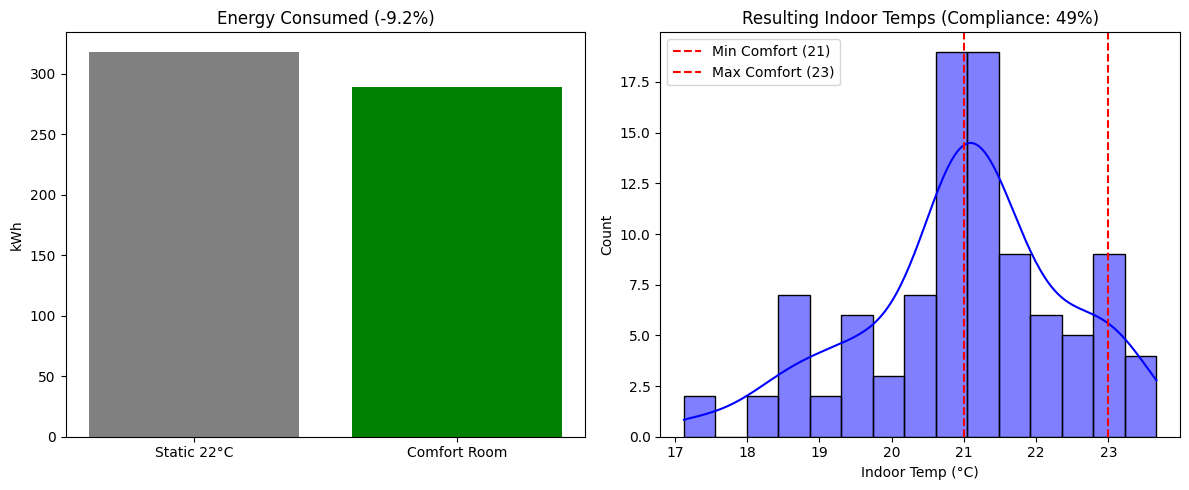

In [12]:
# Visualization of Trade-off
plt.figure(figsize=(12, 5))

# Plot 1: Energy
plt.subplot(1, 2, 1)
plt.bar(['Static 22°C', 'Comfort Room'], [total_base, total_ai], color=['gray', 'green'])
plt.title(f"Energy Consumed (-{savings_pct:.1f}%)")
plt.ylabel("kWh")

# Plot 2: Temperature Distribution
plt.subplot(1, 2, 2)
sns.histplot(results_ai_temp, bins=15, color='blue', kde=True)
plt.axvline(21, color='red', linestyle='--', label='Min Comfort (21)')
plt.axvline(23, color='red', linestyle='--', label='Max Comfort (23)')
plt.title(f"Resulting Indoor Temps (Compliance: {compliance_rate:.0f}%)")
plt.xlabel("Indoor Temp (°C)")
plt.legend()

plt.tight_layout()
plt.show()